# Imports

In [1]:
import numpy as np
import pandas as pd
import os 

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

from joblib import dump, load

In [2]:
df = pd.read_csv("dataset/dataset_with_predicted_mean_A_mean_V.csv")
# df.head()

In [3]:
base_url_clf = 'classifier/randomforest'

# Split dataset into inputs and targets

In [4]:
# drop target value, student annotations and string ID from input features:
X = df.drop(columns=['quadrant','mean_A','mean_V','id','score_mode','score_key_strength'])

# we want to predict the quadrant:
y = df['quadrant'].values

In [5]:
X.head()

,essentia_dissonance_mean,essentia_dissonance_stdev,essentia_dynamic_complexity,essentia_loudness,essentia_onset_rate,essentia_pitch_salience_mean,essentia_pitch_salience_stdev,essentia_spectral_centroid_mean,essentia_spectral_centroid_stdev,essentia_spectral_complexity_mean,...,midlevel_features_melody,midlevel_features_articulation,midlevel_features_rhythm_complexity,midlevel_features_rhythm_stability,midlevel_features_dissonance,midlevel_features_tonal_stability,midlevel_features_minorness,predicted_mean_A,predicted_mean_V,predicted_quadrant
0,0.206445,0.131383,13.998791,58.329521,3.1,0.539736,0.193987,3367.790527,3684.124268,2.986095,...,0.065397,-0.029380,-0.303987,-0.053306,-0.325228,0.347745,-0.119278,45.216172,1.749838,4
1,0.145753,0.057971,3.533264,75.166183,4.2,0.476832,0.123564,1395.528809,401.987610,4.181923,...,0.353040,-0.073957,-0.381182,0.120750,-0.479266,0.451572,-0.064252,42.078254,0.360194,4
2,0.149111,0.059011,3.337368,82.753929,4.3,0.457741,0.132359,1318.759644,289.306152,4.303592,...,0.201885,0.016944,-0.337422,0.103853,-0.388214,0.430684,-0.226197,48.451175,1.963364,4
3,0.163914,0.057474,3.078172,79.024742,4.1,0.504427,0.121134,1258.258423,262.561310,5.271147,...,0.181998,-0.019165,-0.314282,0.118872,-0.335902,0.314371,-0.006619,45.000775,1.033474,4
4,0.157382,0.054116,2.682208,59.633064,3.9,0.503377,0.121658,1244.375122,260.756195,4.122828,...,0.256362,-0.151648,-0.302913,-0.002940,-0.395495,0.368037,-0.162711,31.551966,0.747443,4


<AxesSubplot:>

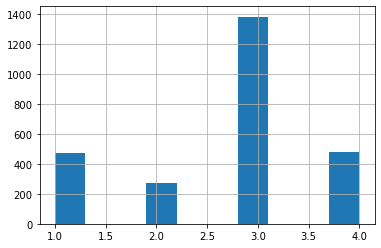

In [6]:
df.quadrant.hist()

In [7]:
#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Simple RandomForest  (no normalization)

In [8]:
# Create DecisionTreeClassifier
clf = ensemble.RandomForestClassifier(max_depth=18, random_state=42)

# Fit the classifier to the data
clf.fit(X_train, y_train)

dump(clf, os.path.join(base_url_clf, 'baseline_maxdepth18_rs42.joblib'))

clf.score(X_test, y_test)

0.7796934865900383

## Normalizing the values improves performance

In [9]:
X_normalized = MinMaxScaler().fit_transform(X)


X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_normalized, y, test_size=0.2, random_state=1, stratify=y)

In [10]:
clf = ensemble.RandomForestClassifier(max_depth=18, random_state=42)

# Fit the classifier to the normalized data
clf.fit(X_train_norm, y_train_norm)

dump(clf, os.path.join(base_url_clf, 'baseline_normalized_maxdepth18_rs42.joblib'))

clf.score(X_test_norm, y_test_norm)

0.7854406130268199

## Derive feature importance directly from the classifier

<AxesSubplot:xlabel='Available features', ylabel='Feature importance score'>

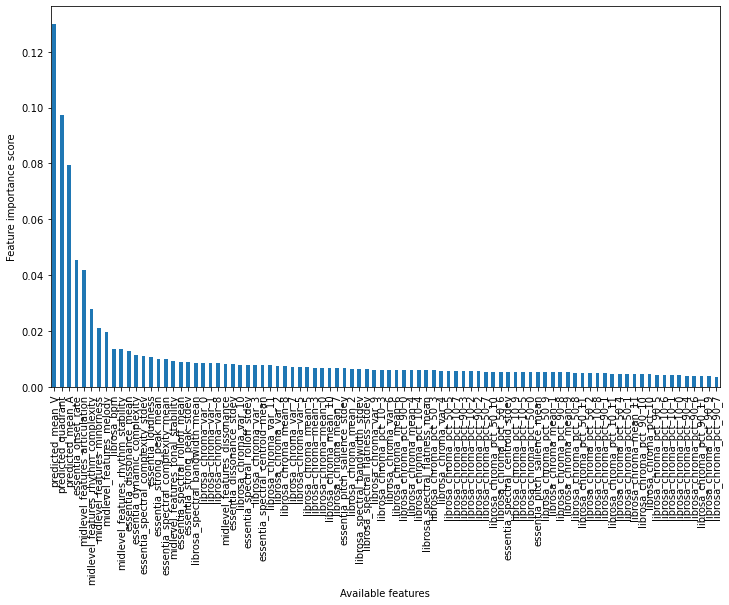

In [11]:
base_feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

base_feature_imp.plot(kind='bar', figsize=(12, 7), xlabel='Available features', ylabel='Feature importance score')

In [12]:
select_k_best = 15

In [13]:
# Drop every but the 15 most important features
X_best = X.drop(columns=[*base_feature_imp.index[select_k_best:]])

#split dataset into train and test data
X_train_best, X_test_best, y_train_best, y_test = train_test_split(X_best, y, test_size=0.2, random_state=1, stratify=y)

In [14]:
# Create DecisionTreeClassifier
clf = ensemble.RandomForestClassifier(max_depth=18, random_state=42)

# Fit the classifier to the selected features only
clf.fit(X_train_best, y_train_best)

dump(clf, os.path.join(base_url_clf, 'feature_selected_maxdepth18_rs42.joblib'))


clf.score(X_test_best, y_test)

0.7931034482758621

<AxesSubplot:xlabel='Available features', ylabel='Feature importance score'>

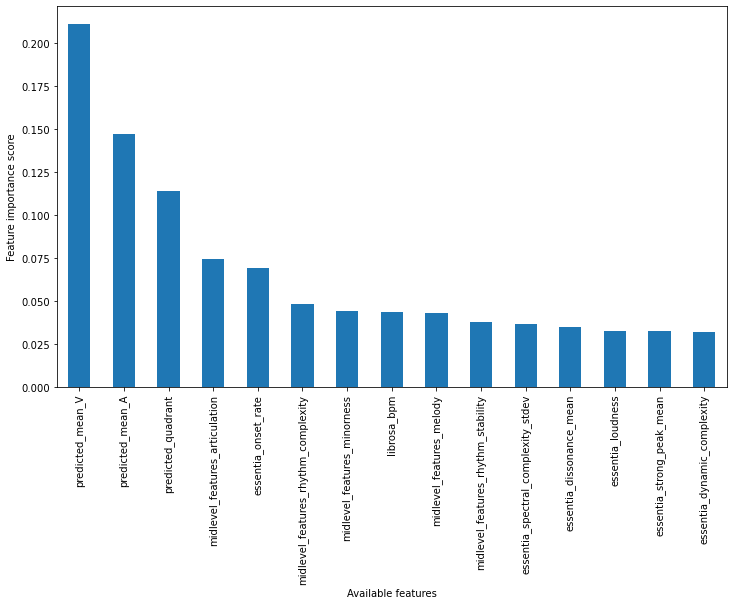

In [15]:
# Re-calculate feature importance 
feature_imp = pd.Series(clf.feature_importances_,index=X_best.columns).sort_values(ascending=False)

feature_imp.plot(kind='bar', figsize=(12, 7), xlabel='Available features', ylabel='Feature importance score')

# RandomForest with Cross-Validation

### Using only the most important features without normalization is apparently the best way, we will stick to that

In [20]:
param_grid = {'n_estimators': [20, 50, 100, 200, 500],
               'max_depth' : [6, 18, 50],
              # 'criterion' :['gini', 'entropy']                 
             }

gscv = GridSearchCV(clf, param_grid, cv=10, return_train_score=True, n_jobs=-1)

gscv.fit(X, y)

scores_all_features = gscv.cv_results_["mean_test_score"]

print("### all 87 features, no normalization ###")
print("best params: ", gscv.best_params_, "\nbest score: ",gscv.best_score_, "\n")

### all 87 features, no normalization ###
best params:  {'max_depth': 50, 'n_estimators': 200} 
best score:  0.7660565870910698 



In [21]:
gscv = GridSearchCV(clf, param_grid, cv=10, return_train_score=True, n_jobs=-1)

gscv.fit(X_best, y)

scores_all_features = gscv.cv_results_["mean_test_score"]

print(f"### only the best {select_k_best} features, no normalization ###")
print("best params: ", gscv.best_params_, "\nbest score: ",gscv.best_score_, "\n")

### only the best 15 features, no normalization ###
best params:  {'max_depth': 6, 'n_estimators': 100} 
best score:  0.7779472443265545 



In [22]:
gscv_norm = GridSearchCV(clf, param_grid, cv=10, return_train_score=True, n_jobs=-1)

gscv_norm.fit(X_normalized, y)

scores_all_features = gscv_norm.cv_results_["mean_test_score"]

print("### all 87 features, normalized to [0, 1] ###")
print("best params: ", gscv_norm.best_params_, "\nbest score: ",gscv_norm.best_score_, "\n")

### all 87 features, normalized to [0, 1] ###
best params:  {'max_depth': 50, 'n_estimators': 500} 
best score:  0.7645254936634247 



In [23]:
gscv_norm = GridSearchCV(clf, param_grid, cv=10, return_train_score=True, n_jobs=-1)

X_best_normalized = MinMaxScaler().fit_transform(X_best)


gscv_norm.fit(X_best_normalized, y)

scores_all_features = gscv_norm.cv_results_["mean_test_score"]

print(f"### only the best {select_k_best} features,, normalized to [0, 1] ###")
print("best params: ", gscv_norm.best_params_, "\nbest score: ",gscv_norm.best_score_, "\n")

### only the best 15 features,, normalized to [0, 1] ###
best params:  {'max_depth': 6, 'n_estimators': 100} 
best score:  0.7771809608016504 



In [ ]:
# max_depth=6, n_estimators=100

In [ ]:
gscv = GridSearchCV(clf, param_grid, cv=10, return_train_score=True, n_jobs=-1)

gscv.fit(X_best, y)

scores_all_features = gscv.cv_results_["mean_test_score"]

print(f"### only the best {select_k_best} features, no normalization ###")
print("best params: ", gscv.best_params_, "\nbest score: ",gscv.best_score_, "\n")

# Evaluation

In [25]:
def plot_search_results(grid, title="Score per parameter", log_list=[]):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle(title, fontsize=26)
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical', fontsize=18)
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper(), fontsize=18)
        if p in log_list: 
            ax[i].set_xscale('log')


    plt.legend()
    plt.show()

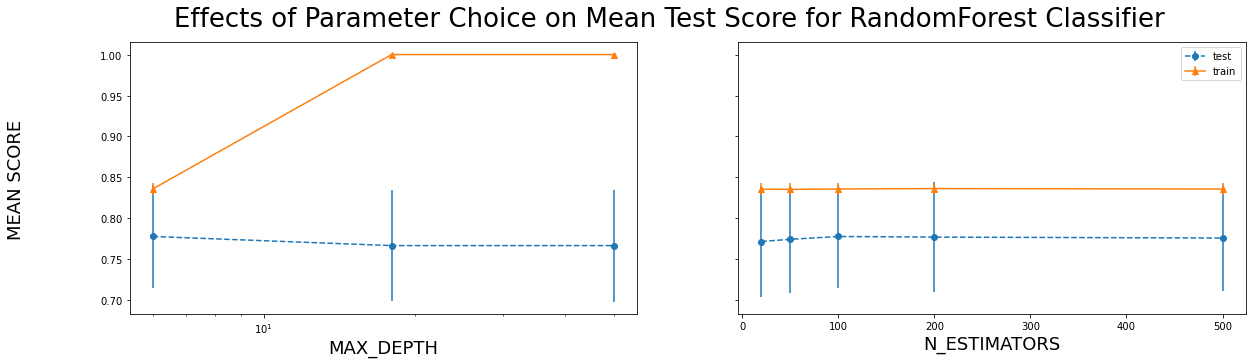

In [27]:
plot_search_results(gscv, title="Effects of Parameter Choice on Mean Test Score for RandomForest Classifier", log_list=["max_depth"])

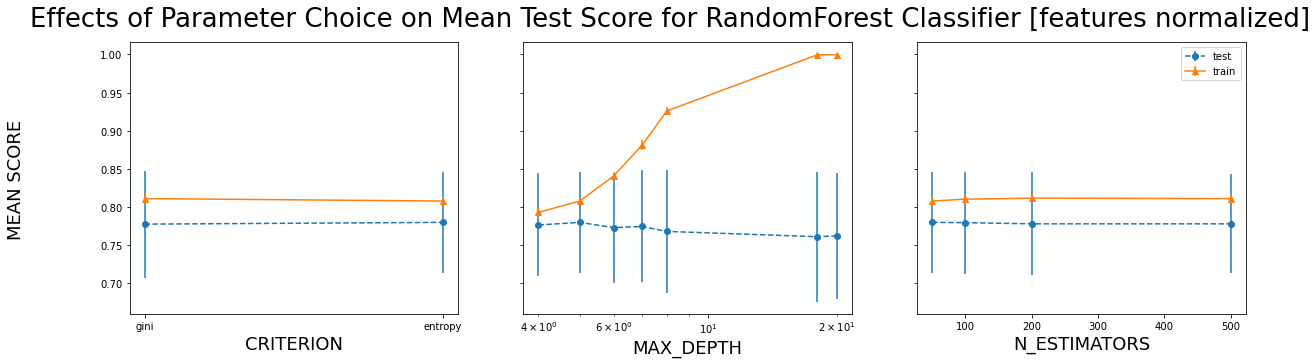

In [94]:
plot_search_results(gscv_norm, title="Effects of Parameter Choice on Mean Test Score for RandomForest Classifier [features normalized]", log_list=["max_depth"])